In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
#Getting Dates to add
def adddates():
    dates = open("dates.txt", "r")
    datelist = []
    for date in dates:
        datelist.append(date.replace("\n", ""))
    return datelist

In [ ]:
#https://towarddatascience.com/how-to-get-stock-data-using-python-c@deIdf17e75
#define ticker symbol

tickerSymbol = "GOOGL" #Stock prices to get
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#historical prices for this ticker

stockdata = tickerData.history(period="1d" , start='2010-1-1' , end='2021-11-10')

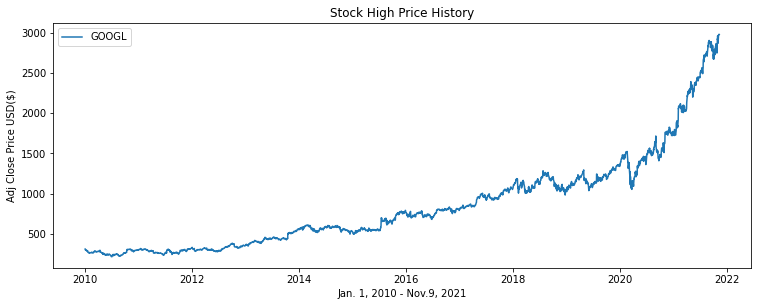

In [ ]:
plt.figure(figsize=(12.5 ,4.5))
plt.plot(stockdata['Close'] ,label = 'GOOGL')
plt.title('Stock High Price History')
plt.xlabel('Jan. 1, 2010 - Nov.9, 2021')
plt.ylabel('Adj Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#creating dataframe
df = pd.DataFrame(stockdata)
df['Date'] = adddates()
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1567,:]
valid = dataset[1567:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/3
1507/1507 - 33s - loss: 1.2972e-04 - 33s/epoch - 22ms/step
Epoch 2/3
1507/1507 - 31s - loss: 5.1306e-05 - 31s/epoch - 20ms/step
Epoch 3/3
1507/1507 - 30s - loss: 3.8099e-05 - 30s/epoch - 20ms/step


In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

130.4788750569954

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


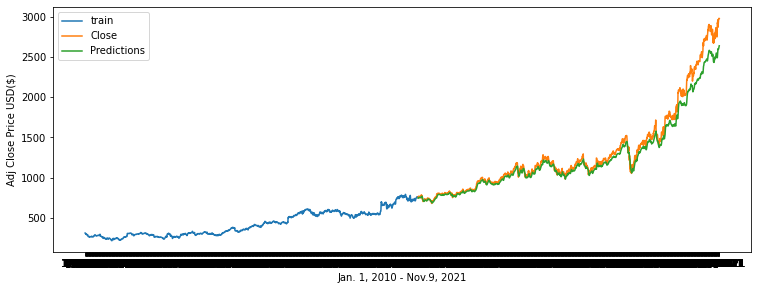

In [ ]:
#for plotting
plt.figure(figsize=(12.5 ,4.5))
train = new_data[:1567]
valid = new_data[1567:]
valid['Predictions'] = closing_price
plt.plot(train['Close'] , label='train')
plt.plot(valid['Close'] ,label='Close')
plt.plot(valid['Predictions'] , label='Predictions')
plt.xlabel('Jan. 1, 2010 - Nov.9, 2021')
plt.ylabel('Adj Close Price USD($)')
plt.legend(loc='upper left')
plt.show()